In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, LGBMRegressor
!pip install catboost
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('../input/univ-ai-hack/train.csv')
test = pd.read_csv('../input/univ-ai-hack/test.csv')

train.rename({'Id': 'id'}, axis=1, inplace=True)

train['tr_te'] = 'train'
test['tr_te'] = 'test'

In [3]:
train.shape, test.shape

((252000, 14), (28000, 13))

In [ ]:
train

In [4]:
def clean_data(df):
    df['state']=df['state'].str.replace(r"\[.*\]","")
    df['state']=df['state'].str.replace("_"," ")
    df['city']=df['city'].str.replace(r"\[.*\]","")
    df['city'] = df['city'].str.strip()
    
    df.replace({'Delhi_city': 'New Delhi',
                'Hubliâ€“Dharwad': 'Hubli-Dharwad',
                'HubliÃ¢â‚¬â€œDharwad': 'Hubli-Dharwad',
                'Karawal_Nagar':'Karawal Nagar',
                'Chandigarh_city':'Chandigarh',
                'Khora, Ghaziabad':'Ghaziabad',
                'Khora,_Ghaziabad':'Ghaziabad',
                'Kirari_Suleman_Nagar':'Kirari Suleman Nagar',
                'Nangloi_Jat':'Nangloi Jat',
                'Navi_Mumbai':'Mumbai',
                'Navi Mumbai':'Mumbai',
                'New_Delhi':'New Delhi',
                'North_Dumdum':'North Dumdum',
                'Rajpur_Sonarpur':'Rajpur Sonarpur',
                'Raurkela Industrial Township':'Rourkela',
                'Raurkela_Industrial_Township':'Rourkela',
                'Sangli-Miraj_&_Kupwad':'Sangli',
                'Sangli-Miraj & Kupwad':'Sangli',
                'South_Dumdum':'South Dumdum',
                'Sri_Ganganagar':'Sri Ganganagar',
                'Sultan_Pur_Majra':'Sultan Pur Majra',
                'Surendranagar_Dudhrej':'Surendranagar Dudhrej',
                'Bhalswa_Jahangir_Pur':'Bhalswa Jahangir Pur',
                'Bihar_Sharif':'Bihar Sharif',
                'Karawal_Nagar':'Karawal Nagar'},inplace= True)
    
    df['profession']=df['profession'].str.replace("_"," ")
    return df

In [5]:
train = clean_data(train)
test = clean_data(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [6]:
## Code for getting data description
def data_description(train):
    variable_analysis = pd.DataFrame(columns = ['Column Name','Data Type','No of Missing', '% Missing', 'Unique Values'])
    for column in list(train.columns):
        if(train[column].dtype == 'O' or train[column].dtype == 'bool'):
            variable_analysis = variable_analysis.append({'Column Name' : column,'Data Type' : 'Object','No of Missing' : sum(pd.isna(train[column])) ,'% Missing' : round(100*sum(pd.isna(train[column]))/train.shape[0],2) ,'Unique Values' : len(train[column].unique())}, ignore_index=True)

 

 

    for column in list(train.columns):
        if(train[column].dtype == 'int64' or train[column].dtype == 'float64'):
            variable_analysis = variable_analysis.append({'Column Name' : column,'Data Type' : 'float64','No of Missing' : sum(pd.isna(train[column])) ,'% Missing' : round(100*sum(pd.isna(train[column]))/train.shape[0],2) ,'Unique Values' : len(train[column].unique())}, ignore_index=True)    

 

    for column in list(train.columns):
        if(train[column].dtype == 'datetime64[ns]'):
            variable_analysis = variable_analysis.append({'Column Name' : column,'Data Type' : 'datetime64[ns]','No of Missing' : sum(pd.isna(train[column])) ,'% Missing' : round(100*sum(pd.isna(train[column]))/train.shape[0],2) ,'Unique Values' : len(train[column].unique())}, ignore_index=True)    

 

 

    return variable_analysis

In [7]:
total = pd.concat([train,test],axis=0)

In [ ]:
# data_description(total)

In [ ]:
total.shape

In [ ]:
# total = clean_data(total)

In [ ]:
# data_description(total)

In [ ]:
total

In [8]:
# features from profession 
profession_feat = total[total['tr_te']=='train'].groupby(['profession']).agg({'risk_flag':['count','sum','mean']}).rename(columns={'count':'profession_freq',
                                                                                                    'sum':'profession_target_sum',
                                                                                                    'mean':'profession_target_mean'})
profession_feat_list = ['profession_freq','profession_target_sum','profession_target_mean']
profession_feat = profession_feat['risk_flag'].reset_index()

# features from city
city_feat = total[total['tr_te']=='train'].groupby(['city']).agg({'risk_flag':['count','sum','mean']}).rename(columns={'count':'city_freq',
                                                                                                    'sum':'city_target_sum',
                                                                                                    'mean':'city_target_mean'})
city_feat_list = ['city_freq','city_target_sum','city_target_mean']
city_feat = city_feat['risk_flag'].reset_index()


# features from state
state_feat = total[total['tr_te']=='train'].groupby(['state']).agg({'risk_flag':['count','sum','mean']}).rename(columns={'count':'state_freq',
                                                                                                    'sum':'state_target_sum',
                                                                                                    'mean':'state_target_mean'})
state_feat_list = ['state_freq','state_target_sum','state_target_mean']
state_feat = state_feat['risk_flag'].reset_index()

In [9]:
# features from state and city 
state_city_feat = total[total['tr_te']=='train'].groupby(['state','city']).agg({'risk_flag':['count','sum','mean']}).rename(columns={'count':'state_city_freq',
                                                                                                    'sum':'state_city_target_sum',
                                                                                                    'mean':'state_city_target_mean'})
state_city_feat_list = ['state_city_freq','state_city_target_sum','state_city_target_mean']
state_city_feat = state_city_feat['risk_flag'].reset_index()

# features from state and profession 
state_prof_feat = total[total['tr_te']=='train'].groupby(['state','profession']).agg({'risk_flag':['count','sum','mean']}).rename(columns={'count':'state_prof_freq',
                                                                                                    'sum':'state_prof_target_sum',
                                                                                                    'mean':'state_prof_target_mean'})
state_prof_feat_list = ['state_prof_freq','state_prof_target_sum','state_prof_target_mean']
state_prof_feat = state_prof_feat['risk_flag'].reset_index()

# features from state,city and profession 
state_city_prof_feat = total[total['tr_te']=='train'].groupby(['state','city','profession']).agg({'risk_flag':['count','sum','mean']}).rename(columns={'count':'state_city_prof_freq',
                                                                                                    'sum':'state_city_prof_target_sum',
                                                                                                    'mean':'state_city_prof_target_mean'})
state_city_prof_feat_list = ['state_city_prof_freq','state_city_prof_target_sum','state_city_prof_target_mean']
state_city_prof_feat = state_city_prof_feat['risk_flag'].reset_index()

In [ ]:
total.columns

In [10]:
total['income_age_ratio'] = total['income'] / total['age']
total['income_experience_ratio'] = total['income'] / (total['experience']+1)
total['experience_age_ratio'] = total['experience'] / total['age']

total['current_job_years_age_ratio'] = total['current_job_years'] / total['age']
total['current_job_years_experience_ratio'] = total['current_job_years'] / (total['experience']+1)

ratio_feats = ['income_age_ratio','income_experience_ratio','experience_age_ratio','current_job_years_age_ratio','current_job_years_experience_ratio']

In [ ]:
total.shape

In [11]:
# merging with data
total =  pd.merge(total,profession_feat, on='profession',how="left")
total =  pd.merge(total,city_feat, on='city',how="left")
total =  pd.merge(total,state_feat, on='state',how="left")
total =  pd.merge(total,state_city_feat, on=['state','city'],how="left")
total =  pd.merge(total,state_prof_feat, on=['state','profession'], how="left")
total =  pd.merge(total,state_city_prof_feat, on=['state','city','profession'],how="left")

In [ ]:
total

In [12]:
char_col_list = ['married','house_ownership','car_ownership','profession','city','state']
le = LabelEncoder()

for col in char_col_list:
    total[col]= le.fit_transform(total[col])

In [13]:
standardization = True
if standardization:
    col_standardization = ['income','age', 'experience','current_job_years']
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    total[col_standardization] = sc.fit_transform(total[col_standardization])

In [ ]:
state_city_prof_feat_list

In [ ]:
ratio_feats

In [14]:
state_city_prof_feat_list = ['state_city_prof_freq','state_city_prof_target_sum']

In [15]:
base_feat_list = ['income','age','experience','house_ownership','car_ownership','profession','city','state','current_job_years','current_house_years']

count_feat_list = ['profession_freq','city_freq','state_freq','state_city_freq','state_prof_freq','state_city_prof_freq']
sum_feat_list = ['profession_target_sum','city_target_sum','state_target_sum','state_city_target_sum','state_prof_target_sum','state_city_prof_target_sum']

final_feat_list = base_feat_list  # + profession_feat_list + city_feat_list + state_feat_list + state_city_feat_list + state_prof_feat_list + state_city_prof_feat_list
final_feat_list.append(ratio_feats[0])
final_feat_list.append(ratio_feats[3])
final_feat_list.append(ratio_feats[4])

target_col = ['risk_flag']

len(final_feat_list)

13

In [16]:
final_feat_list

['income',
 'age',
 'experience',
 'house_ownership',
 'car_ownership',
 'profession',
 'city',
 'state',
 'current_job_years',
 'current_house_years',
 'income_age_ratio',
 'current_job_years_age_ratio',
 'current_job_years_experience_ratio']

In [17]:
# getting index of categorical features
cat_feat_list = ['house_ownership','car_ownership','profession','city','state','current_house_years']  # current_job_years current_house_years
categorical_features_indices = []
for i in range(len(final_feat_list)):
    if final_feat_list[i] in cat_feat_list:
        print(final_feat_list[i],'\n')
        categorical_features_indices.append(i)

categorical_features_indices

house_ownership 

car_ownership 

profession 

city 

state 

current_house_years 



[3, 4, 5, 6, 7, 9]

In [18]:
train_df = total[total['tr_te']=='train']

In [20]:
##Splitting data
X_train, X_test, y_train, y_test=train_test_split(train_df[final_feat_list],
                                                  train_df[target_col],
                                                  stratify = train_df[target_col],
                                                  test_size = 0.3,
                                                  random_state=10)

In [21]:
oofs_pred = pd.DataFrame()
oofs_pred['risk_flag'] = y_test['risk_flag'].values
    
# hold-out validation 
#oofs_pred['cb_pred_prob'] = -10000000
# oofs_pct = np.zeros((len(train_df), 3))
final_models = {}
final_params = {}

for fold_ in range(10):

    params = {
        'learning_rate': 0.2,
        'colsample_bytree': 1,
        'reg_alpha': 1,
        'reg_lambda': 1,
        'max_depth': -1,
        'n_estimators': 5000,
        'subsample_for_bin': 100000000000,
        #'max_bin': 24*5,
        'metric':'auc',
        'num_leaves': np.random.choice([255,500,750]), #np.random.choice([43, 127, 34, 255, 18]),
        'min_child_samples':np.random.choice([3, 10, 5, 7, 2])
    }


    cb_class_model = LGBMClassifier(**params)
    cb_class_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=10, early_stopping_rounds = 100)
        
    final_models[f'model_cb_class_{fold_}'] = cb_class_model

    cb_class_pred = cb_class_model.predict_proba(X_test)[:,1]
    oofs_pred[f'model_cb_class_{fold_}'] = cb_class_pred

    fold_score = roc_auc_score(y_test.values,cb_class_pred)
    print('Fold score:',fold_score,'\n')

    temp_params = params.copy()
    temp_params['n_estimators'] = cb_class_model.best_iteration_
    final_params[fold_] = temp_params
    print(final_params,'\n')
    
    
# print('Overall Score:', roc_auc_score(oofs_pred['risk_flag'],oofs_pred['cb_pred_prob']) )

# bestTest = 0.9282978696

# bestTest = 0.93631712 703 cb base feat 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.911564
[20]	valid_0's auc: 0.924293
[30]	valid_0's auc: 0.929397
[40]	valid_0's auc: 0.931056
[50]	valid_0's auc: 0.93245
[60]	valid_0's auc: 0.933224
[70]	valid_0's auc: 0.933695
[80]	valid_0's auc: 0.933991
[90]	valid_0's auc: 0.934094
[100]	valid_0's auc: 0.934154
[110]	valid_0's auc: 0.934226
[120]	valid_0's auc: 0.934295
[130]	valid_0's auc: 0.934245
[140]	valid_0's auc: 0.934297
[150]	valid_0's auc: 0.934223
[160]	valid_0's auc: 0.934233
[170]	valid_0's auc: 0.93422
[180]	valid_0's auc: 0.934152
[190]	valid_0's auc: 0.934151
[200]	valid_0's auc: 0.934157
[210]	valid_0's auc: 0.934133
[220]	valid_0's auc: 0.934109
[230]	valid_0's auc: 0.934038
Early stopping, best iteration is:
[138]	valid_0's auc: 0.934318
Fold score: 0.9343183770119661 

{0: {'learning_rate': 0.2, 'colsample_bytree': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'max_depth': -1, 'n_estimators': 138, 'subsample_for_bin': 100000000000, 'metr

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.882608
[20]	valid_0's auc: 0.901353
[30]	valid_0's auc: 0.91133
[40]	valid_0's auc: 0.917592
[50]	valid_0's auc: 0.920059
[60]	valid_0's auc: 0.921241
[70]	valid_0's auc: 0.923402
[80]	valid_0's auc: 0.924643
[90]	valid_0's auc: 0.926276
[100]	valid_0's auc: 0.927335
[110]	valid_0's auc: 0.927799
[120]	valid_0's auc: 0.929061
[130]	valid_0's auc: 0.929588
[140]	valid_0's auc: 0.929942
[150]	valid_0's auc: 0.930321
[160]	valid_0's auc: 0.930366
[170]	valid_0's auc: 0.930925
[180]	valid_0's auc: 0.931482
[190]	valid_0's auc: 0.931816
[200]	valid_0's auc: 0.932189
[210]	valid_0's auc: 0.932508
[220]	valid_0's auc: 0.932913
[230]	valid_0's auc: 0.933111
[240]	valid_0's auc: 0.933304
[250]	valid_0's auc: 0.933368
[260]	valid_0's auc: 0.933449
[270]	valid_0's auc: 0.933543
[280]	valid_0's auc: 0.933546
[290]	valid_0's auc: 0.933642
[300]	valid_0's auc: 0.933692
[310]	valid_0's auc: 0.933799
[320]	valid_0's au

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.906658
[20]	valid_0's auc: 0.920461
[30]	valid_0's auc: 0.924405
[40]	valid_0's auc: 0.926837
[50]	valid_0's auc: 0.928851
[60]	valid_0's auc: 0.931144
[70]	valid_0's auc: 0.932217
[80]	valid_0's auc: 0.932816
[90]	valid_0's auc: 0.933367
[100]	valid_0's auc: 0.933666
[110]	valid_0's auc: 0.93407
[120]	valid_0's auc: 0.934382
[130]	valid_0's auc: 0.934463
[140]	valid_0's auc: 0.934564
[150]	valid_0's auc: 0.934548
[160]	valid_0's auc: 0.934627
[170]	valid_0's auc: 0.934802
[180]	valid_0's auc: 0.934782
[190]	valid_0's auc: 0.934737
[200]	valid_0's auc: 0.934769
[210]	valid_0's auc: 0.934784
[220]	valid_0's auc: 0.934764
[230]	valid_0's auc: 0.934676
[240]	valid_0's auc: 0.934656
[250]	valid_0's auc: 0.934634
[260]	valid_0's auc: 0.934595
[270]	valid_0's auc: 0.934535
Early stopping, best iteration is:
[176]	valid_0's auc: 0.934808
Fold score: 0.9348083978226768 

{0: {'learning_rate': 0.2, 'colsample_by

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.911564
[20]	valid_0's auc: 0.924293
[30]	valid_0's auc: 0.929397
[40]	valid_0's auc: 0.931056
[50]	valid_0's auc: 0.93245
[60]	valid_0's auc: 0.933224
[70]	valid_0's auc: 0.933695
[80]	valid_0's auc: 0.933991
[90]	valid_0's auc: 0.934094
[100]	valid_0's auc: 0.934154
[110]	valid_0's auc: 0.934226
[120]	valid_0's auc: 0.934295
[130]	valid_0's auc: 0.934245
[140]	valid_0's auc: 0.934297
[150]	valid_0's auc: 0.934223
[160]	valid_0's auc: 0.934233
[170]	valid_0's auc: 0.93422
[180]	valid_0's auc: 0.934152
[190]	valid_0's auc: 0.934151
[200]	valid_0's auc: 0.934157
[210]	valid_0's auc: 0.934133
[220]	valid_0's auc: 0.934109
[230]	valid_0's auc: 0.934038
Early stopping, best iteration is:
[138]	valid_0's auc: 0.934318
Fold score: 0.9343183770119661 

{0: {'learning_rate': 0.2, 'colsample_bytree': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'max_depth': -1, 'n_estimators': 138, 'subsample_for_bin': 100000000000, 'metr

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.882608
[20]	valid_0's auc: 0.901386
[30]	valid_0's auc: 0.911013
[40]	valid_0's auc: 0.915984
[50]	valid_0's auc: 0.919286
[60]	valid_0's auc: 0.922725
[70]	valid_0's auc: 0.924458
[80]	valid_0's auc: 0.925661
[90]	valid_0's auc: 0.927311
[100]	valid_0's auc: 0.92852
[110]	valid_0's auc: 0.929528
[120]	valid_0's auc: 0.930793
[130]	valid_0's auc: 0.931301
[140]	valid_0's auc: 0.931818
[150]	valid_0's auc: 0.932088
[160]	valid_0's auc: 0.932331
[170]	valid_0's auc: 0.932458
[180]	valid_0's auc: 0.93298
[190]	valid_0's auc: 0.933217
[200]	valid_0's auc: 0.933427
[210]	valid_0's auc: 0.933504
[220]	valid_0's auc: 0.933656
[230]	valid_0's auc: 0.933855
[240]	valid_0's auc: 0.933939
[250]	valid_0's auc: 0.934008
[260]	valid_0's auc: 0.934044
[270]	valid_0's auc: 0.934198
[280]	valid_0's auc: 0.934246
[290]	valid_0's auc: 0.934401
[300]	valid_0's auc: 0.934481
[310]	valid_0's auc: 0.934608
[320]	valid_0's auc

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.913398
[20]	valid_0's auc: 0.926281
[30]	valid_0's auc: 0.929904
[40]	valid_0's auc: 0.931663
[50]	valid_0's auc: 0.933216
[60]	valid_0's auc: 0.933809
[70]	valid_0's auc: 0.934441
[80]	valid_0's auc: 0.934805
[90]	valid_0's auc: 0.934948
[100]	valid_0's auc: 0.935014
[110]	valid_0's auc: 0.935113
[120]	valid_0's auc: 0.93509
[130]	valid_0's auc: 0.934974
[140]	valid_0's auc: 0.935032
[150]	valid_0's auc: 0.9351
[160]	valid_0's auc: 0.935087
[170]	valid_0's auc: 0.93505
[180]	valid_0's auc: 0.934949
[190]	valid_0's auc: 0.93492
[200]	valid_0's auc: 0.934888
Early stopping, best iteration is:
[106]	valid_0's auc: 0.935141
Fold score: 0.9351414894825443 

{0: {'learning_rate': 0.2, 'colsample_bytree': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'max_depth': -1, 'n_estimators': 138, 'subsample_for_bin': 100000000000, 'metric': 'auc', 'num_leaves': 750, 'min_child_samples': 7}, 1: {'learning_rate': 0.2, 'colsample_

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.882608
[20]	valid_0's auc: 0.901353
[30]	valid_0's auc: 0.91133
[40]	valid_0's auc: 0.917592
[50]	valid_0's auc: 0.920059
[60]	valid_0's auc: 0.921241
[70]	valid_0's auc: 0.923402
[80]	valid_0's auc: 0.924643
[90]	valid_0's auc: 0.926276
[100]	valid_0's auc: 0.927335
[110]	valid_0's auc: 0.927799
[120]	valid_0's auc: 0.929061
[130]	valid_0's auc: 0.929588
[140]	valid_0's auc: 0.929942
[150]	valid_0's auc: 0.930321
[160]	valid_0's auc: 0.930366
[170]	valid_0's auc: 0.930925
[180]	valid_0's auc: 0.931482
[190]	valid_0's auc: 0.931816
[200]	valid_0's auc: 0.932189
[210]	valid_0's auc: 0.932508
[220]	valid_0's auc: 0.932913
[230]	valid_0's auc: 0.933111
[240]	valid_0's auc: 0.933304
[250]	valid_0's auc: 0.933368
[260]	valid_0's auc: 0.933449
[270]	valid_0's auc: 0.933543
[280]	valid_0's auc: 0.933546
[290]	valid_0's auc: 0.933642
[300]	valid_0's auc: 0.933692
[310]	valid_0's auc: 0.933799
[320]	valid_0's au

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.913455
[20]	valid_0's auc: 0.926178
[30]	valid_0's auc: 0.930511
[40]	valid_0's auc: 0.932639
[50]	valid_0's auc: 0.933009
[60]	valid_0's auc: 0.933825
[70]	valid_0's auc: 0.934265
[80]	valid_0's auc: 0.934558
[90]	valid_0's auc: 0.934815
[100]	valid_0's auc: 0.934887
[110]	valid_0's auc: 0.934913
[120]	valid_0's auc: 0.934928
[130]	valid_0's auc: 0.935016
[140]	valid_0's auc: 0.935021
[150]	valid_0's auc: 0.93497
[160]	valid_0's auc: 0.934919
[170]	valid_0's auc: 0.934839
[180]	valid_0's auc: 0.934791
[190]	valid_0's auc: 0.934797
[200]	valid_0's auc: 0.934799
[210]	valid_0's auc: 0.934853
[220]	valid_0's auc: 0.934849
[230]	valid_0's auc: 0.934811
Early stopping, best iteration is:
[136]	valid_0's auc: 0.93503
Fold score: 0.9350300745216071 

{0: {'learning_rate': 0.2, 'colsample_bytree': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'max_depth': -1, 'n_estimators': 138, 'subsample_for_bin': 100000000000, 'metr

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.913355
[20]	valid_0's auc: 0.925435
[30]	valid_0's auc: 0.927942
[40]	valid_0's auc: 0.930708
[50]	valid_0's auc: 0.93196
[60]	valid_0's auc: 0.932848
[70]	valid_0's auc: 0.933205
[80]	valid_0's auc: 0.933719
[90]	valid_0's auc: 0.934074
[100]	valid_0's auc: 0.934237
[110]	valid_0's auc: 0.934305
[120]	valid_0's auc: 0.934264
[130]	valid_0's auc: 0.934476
[140]	valid_0's auc: 0.93463
[150]	valid_0's auc: 0.934531
[160]	valid_0's auc: 0.934514
[170]	valid_0's auc: 0.934464
[180]	valid_0's auc: 0.93438
[190]	valid_0's auc: 0.934319
[200]	valid_0's auc: 0.934351
[210]	valid_0's auc: 0.934274
[220]	valid_0's auc: 0.934206
[230]	valid_0's auc: 0.934217
[240]	valid_0's auc: 0.934233
Early stopping, best iteration is:
[140]	valid_0's auc: 0.93463
Fold score: 0.9346301137727099 

{0: {'learning_rate': 0.2, 'colsample_bytree': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'max_depth': -1, 'n_estimators': 138, 'subsample_f

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[10]	valid_0's auc: 0.912927
[20]	valid_0's auc: 0.924604
[30]	valid_0's auc: 0.928598
[40]	valid_0's auc: 0.930684
[50]	valid_0's auc: 0.932863
[60]	valid_0's auc: 0.933668
[70]	valid_0's auc: 0.934066
[80]	valid_0's auc: 0.934371
[90]	valid_0's auc: 0.934489
[100]	valid_0's auc: 0.934677
[110]	valid_0's auc: 0.934792
[120]	valid_0's auc: 0.934812
[130]	valid_0's auc: 0.934884
[140]	valid_0's auc: 0.934881
[150]	valid_0's auc: 0.934943
[160]	valid_0's auc: 0.934937
[170]	valid_0's auc: 0.934916
[180]	valid_0's auc: 0.934913
[190]	valid_0's auc: 0.934863
[200]	valid_0's auc: 0.934848
[210]	valid_0's auc: 0.93483
[220]	valid_0's auc: 0.934821
[230]	valid_0's auc: 0.934821
[240]	valid_0's auc: 0.934825
[250]	valid_0's auc: 0.934812
[260]	valid_0's auc: 0.934774
Early stopping, best iteration is:
[165]	valid_0's auc: 0.934985
Fold score: 0.9349852967075327 

{0: {'learning_rate': 0.2, 'colsample_bytree': 1, 'reg_alpha': 1, 'reg

In [ ]:

# Overall Score: 0.9229431038572502   0.68 catboost with no data cleaning 

# bestTest = 0.9373889929  bestIteration = 764 sud

In [25]:
oofs_pred

,risk_flag,model_cb_class_0,model_cb_class_1,model_cb_class_2,model_cb_class_3,model_cb_class_4,model_cb_class_5,model_cb_class_6,model_cb_class_7,model_cb_class_8,model_cb_class_9
0,0.0,0.006349,0.013951,0.021495,0.006349,0.025427,0.011113,0.013951,0.027230,0.040789,0.016349
1,0.0,0.001617,0.001193,0.004427,0.001617,0.000805,0.003123,0.001193,0.003698,0.002964,0.003354
2,0.0,0.001005,0.001133,0.002555,0.001005,0.000932,0.002863,0.001133,0.000675,0.001015,0.001264
3,0.0,0.001459,0.001272,0.001769,0.001459,0.000985,0.003698,0.001272,0.001800,0.001597,0.000625
4,0.0,0.003193,0.001803,0.002970,0.003193,0.004881,0.005394,0.001803,0.002813,0.004293,0.003175
...,...,...,...,...,...,...,...,...,...,...,...
75595,0.0,0.091774,0.011663,0.050961,0.091774,0.024567,0.122404,0.011663,0.013999,0.038135,0.103672
75596,0.0,0.675603,0.681368,0.678542,0.675603,0.677784,0.683345,0.681368,0.675434,0.675857,0.681721
75597,0.0,0.003267,0.001458,0.004038,0.003267,0.003058,0.003549,0.001458,0.002652,0.002938,0.001591
75598,0.0,0.001601,0.001903,0.004275,0.001601,0.002176,0.003712,0.001903,0.002808,0.003253,0.002351


In [27]:
temp_cols  = list(oofs_pred.columns)[1:11]
temp_cols

['model_cb_class_0',
 'model_cb_class_1',
 'model_cb_class_2',
 'model_cb_class_3',
 'model_cb_class_4',
 'model_cb_class_5',
 'model_cb_class_6',
 'model_cb_class_7',
 'model_cb_class_8',
 'model_cb_class_9']

In [30]:
oofs_pred['model_cb_class_0'] = oofs_pred[temp_cols].mean(axis = 1)

In [31]:
oofs_pred['cb_pred_prob'] = oofs_pred['model_cb_class_0']

In [32]:
oofs_pred

,risk_flag,model_cb_class_0,model_cb_class_1,model_cb_class_2,model_cb_class_3,model_cb_class_4,model_cb_class_5,model_cb_class_6,model_cb_class_7,model_cb_class_8,model_cb_class_9,cb_pred_prob
0,0.0,0.018300,0.013951,0.021495,0.006349,0.025427,0.011113,0.013951,0.027230,0.040789,0.016349,0.018300
1,0.0,0.002399,0.001193,0.004427,0.001617,0.000805,0.003123,0.001193,0.003698,0.002964,0.003354,0.002399
2,0.0,0.001358,0.001133,0.002555,0.001005,0.000932,0.002863,0.001133,0.000675,0.001015,0.001264,0.001358
3,0.0,0.001593,0.001272,0.001769,0.001459,0.000985,0.003698,0.001272,0.001800,0.001597,0.000625,0.001593
4,0.0,0.003352,0.001803,0.002970,0.003193,0.004881,0.005394,0.001803,0.002813,0.004293,0.003175,0.003352
...,...,...,...,...,...,...,...,...,...,...,...,...
75595,0.0,0.056061,0.011663,0.050961,0.091774,0.024567,0.122404,0.011663,0.013999,0.038135,0.103672,0.056061
75596,0.0,0.678663,0.681368,0.678542,0.675603,0.677784,0.683345,0.681368,0.675434,0.675857,0.681721,0.678663
75597,0.0,0.002728,0.001458,0.004038,0.003267,0.003058,0.003549,0.001458,0.002652,0.002938,0.001591,0.002728
75598,0.0,0.002558,0.001903,0.004275,0.001601,0.002176,0.003712,0.001903,0.002808,0.003253,0.002351,0.002558


In [59]:
score = []
for i in np.arange(0,1, 0.005):
    y_pred = oofs_pred['cb_pred_prob']
    y_predicted = np.where(y_pred > i,1,0)
    score.append(roc_auc_score(oofs_pred['risk_flag'].values, y_predicted))

Text(0.5, 1.0, 'Plotting F1 Score for Different Threshold Values to Find Optimal Threshold')

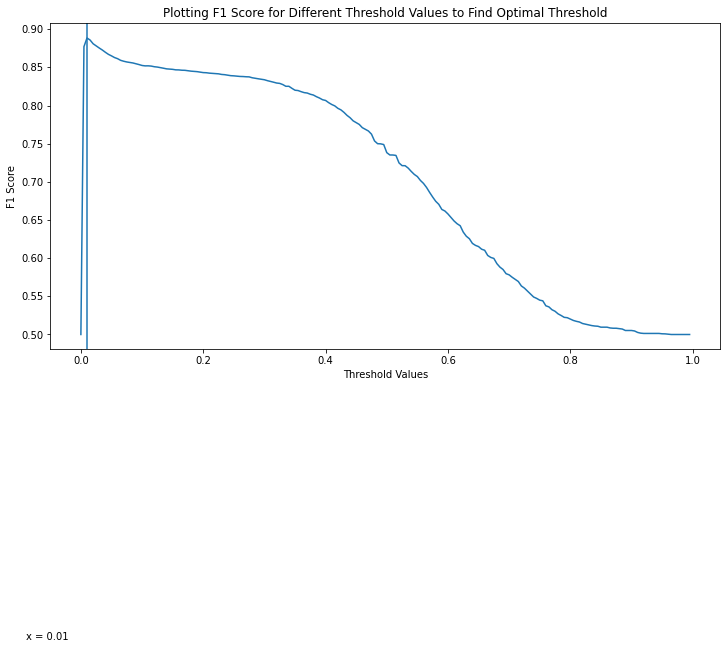

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(np.arange(0,1, 0.005), score)
plt.axvline(x = np.arange(0,1,0.005)[score.index(max(score))])
ax.text(np.arange(0,1,0.005)[score.index(max(score))]-0.1, 0.1, f"x = {np.arange(0,1,0.005)[score.index(max(score))]}")
ax.set_xlabel("Threshold Values")
ax.set_ylabel("F1 Score")
ax.set_title("Plotting F1 Score for Different Threshold Values to Find Optimal Threshold")

In [49]:
thres = 0.009

In [50]:
(oofs_pred['cb_pred_prob']>thres).value_counts(normalize=True)

False    0.695992
True     0.304008
Name: cb_pred_prob, dtype: float64

In [51]:
roc_auc_score(oofs_pred['risk_flag'], np.where(oofs_pred['cb_pred_prob']>0.009,1,0))

0.8891401464141258

In [ ]:
# def plot_feature_importance(importance,names,model_type):
    
#     #Create arrays from feature importance and feature names
#     feature_importance = np.array(importance)
#     feature_names = np.array(names)
    
#     #Create a DataFrame using a Dictionary
#     data={'feature_names':feature_names,'feature_importance':feature_importance}
#     fi_df = pd.DataFrame(data)
    
#     #Sort the DataFrame in order decreasing feature importance
#     fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
#     #Define size of bar plot
#     plt.figure(figsize=(10,8))
#     #Plot Searborn bar chart
#     sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#     #Add chart labels
#     plt.title(model_type + 'FEATURE IMPORTANCE')
#     plt.xlabel('FEATURE IMPORTANCE')
#     plt.ylabel('FEATURE NAMES')

In [ ]:
# plot_feature_importance(cb_class_model.get_feature_importance(),features,'CATBOOST')

In [ ]:

lgbm.plot_importance(cb_class_model, max_num_features=50)

#### Making Prediction for submission

In [24]:
models = {}
test_df = total[total['tr_te']=='test']
sub_pred_df = pd.DataFrame()
    
for i in range(10):
    final_cb_params = final_params[i]
    print(i,'\n',final_cb_params,'\n')
    models[f'model_cb_class_{i}'] =  LGBMClassifier(**final_cb_params,verbose=200)
    models[f'model_cb_class_{i}'].fit(train_df[final_feat_list],train_df[target_col])
    
    sub_pred_df[f'model_cb_prob_{i}'] = models[f'model_cb_class_{i}'].predict_proba(test_df[final_feat_list])[:,1]

0 
 {'learning_rate': 0.2, 'colsample_bytree': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'max_depth': -1, 'n_estimators': 138, 'subsample_for_bin': 100000000000, 'metric': 'auc', 'num_leaves': 750, 'min_child_samples': 7} 



/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.010052 seconds, init for row-wise cost 0.031036 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 30
[LightGBM] [Debug] Trained a tr

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.010041 seconds, init for row-wise cost 0.030589 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_dept

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.009913 seconds, init for row-wise cost 0.032497 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 500 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 500 and max_dept

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.167375 seconds, init for row-wise cost 0.100175 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_dept

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.008281 seconds, init for row-wise cost 0.030782 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_dept

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.009568 seconds, init for row-wise cost 0.031531 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 30
[LightGBM] [Debug] Trained a tr

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.010181 seconds, init for row-wise cost 0.031481 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 255 and max_depth = 24
[LightGBM] [Debug] Trained a tr

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.010300 seconds, init for row-wise cost 0.030410 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 31
[LightGBM] [Debug] Trained a tr

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.009611 seconds, init for row-wise cost 0.031553 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 30
[LightGBM] [Debug] Trained a tr

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Info] Number of positive: 30996, number of negative: 221004
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.809321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.140878
[LightGBM] [Debug] init for col-wise cost 0.009668 seconds, init for row-wise cost 0.031519 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123000 -> initscore=-1.964323
[LightGBM] [Info] Start training from score -1.964323
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 37
[LightGBM] [Debug] Trained a tree with leaves = 750 and max_depth = 30
[LightGBM] [Debug] Trained a tr

In [63]:
sub_pred_df

,model_cb_prob_0,model_cb_prob_1,model_cb_prob_2,model_cb_prob_3,model_cb_prob_4,model_cb_prob_5,model_cb_prob_6,model_cb_prob_7,model_cb_prob_8,model_cb_prob_9,model_cb_prob,binary_pred
0,0.000937,0.000585,0.000440,0.000937,0.000842,0.001810,0.000585,0.000893,0.000780,0.000449,0.019495,1
1,0.002744,0.003668,0.005011,0.002744,0.006025,0.006852,0.003668,0.002993,0.003421,0.002590,0.002477,0
2,0.003843,0.004404,0.002887,0.003843,0.002340,0.005299,0.004404,0.003075,0.003769,0.002159,0.001393,0
3,0.233893,0.144744,0.015746,0.233893,0.074573,0.154407,0.144744,0.112659,0.068240,0.170779,0.001607,0
4,0.001589,0.001836,0.001257,0.001589,0.001787,0.002370,0.001836,0.001837,0.002569,0.001670,0.003368,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.001767,0.001091,0.002211,0.001767,0.002130,0.002400,0.001091,0.002354,0.002605,0.001103,0.002930,0
27996,0.003110,0.002234,0.003729,0.003110,0.003276,0.002489,0.002234,0.002265,0.002543,0.002097,0.002159,0
27997,0.002485,0.003183,0.006912,0.002485,0.002790,0.004588,0.003183,0.003086,0.003282,0.002065,0.002407,0
27998,0.047404,0.157790,0.053923,0.047404,0.037317,0.161874,0.157790,0.182459,0.143158,0.226032,0.755521,1


In [65]:
temp_cols1 = list(sub_pred_df.columns)[0:10]
temp_cols1

['model_cb_prob_0',
 'model_cb_prob_1',
 'model_cb_prob_2',
 'model_cb_prob_3',
 'model_cb_prob_4',
 'model_cb_prob_5',
 'model_cb_prob_6',
 'model_cb_prob_7',
 'model_cb_prob_8',
 'model_cb_prob_9']

In [67]:
sub_pred_df['model_cb_prob'] = sub_pred_df[temp_cols1].mean(axis = 1)
sub_pred_df

,model_cb_prob_0,model_cb_prob_1,model_cb_prob_2,model_cb_prob_3,model_cb_prob_4,model_cb_prob_5,model_cb_prob_6,model_cb_prob_7,model_cb_prob_8,model_cb_prob_9,model_cb_prob,binary_pred
0,0.000937,0.000585,0.000440,0.000937,0.000842,0.001810,0.000585,0.000893,0.000780,0.000449,0.000826,1
1,0.002744,0.003668,0.005011,0.002744,0.006025,0.006852,0.003668,0.002993,0.003421,0.002590,0.003972,0
2,0.003843,0.004404,0.002887,0.003843,0.002340,0.005299,0.004404,0.003075,0.003769,0.002159,0.003602,0
3,0.233893,0.144744,0.015746,0.233893,0.074573,0.154407,0.144744,0.112659,0.068240,0.170779,0.135368,0
4,0.001589,0.001836,0.001257,0.001589,0.001787,0.002370,0.001836,0.001837,0.002569,0.001670,0.001834,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.001767,0.001091,0.002211,0.001767,0.002130,0.002400,0.001091,0.002354,0.002605,0.001103,0.001852,0
27996,0.003110,0.002234,0.003729,0.003110,0.003276,0.002489,0.002234,0.002265,0.002543,0.002097,0.002709,0
27997,0.002485,0.003183,0.006912,0.002485,0.002790,0.004588,0.003183,0.003086,0.003282,0.002065,0.003406,0
27998,0.047404,0.157790,0.053923,0.047404,0.037317,0.161874,0.157790,0.182459,0.143158,0.226032,0.121515,1


In [68]:
thres

0.009

In [69]:
sub_pred_df['binary_pred'] = np.where(sub_pred_df['model_cb_prob'] >thres,1,0)
sub_pred_df['binary_pred'].value_counts(normalize=True)*100


0    69.0
1    31.0
Name: binary_pred, dtype: float64

In [70]:
# class prediction
sub_class = test_df[['id','risk_flag']].reset_index()
sub_class['risk_flag'] = sub_pred_df['binary_pred'] 
sub_class[['id','risk_flag']].to_csv('sub_lgbm_10ens__thres_0.009.csv',index=False)

sub_class['risk_flag'].value_counts(normalize=True)*100

0    69.0
1    31.0
Name: risk_flag, dtype: float64

In [58]:
sub_class

,index,id,risk_flag
0,252000,1,1
1,252001,2,0
2,252002,3,0
3,252003,4,0
4,252004,5,0
...,...,...,...
27995,279995,27996,0
27996,279996,27997,0
27997,279997,27998,0
27998,279998,27999,1


In [ ]:
models = {}
final_cb_params = params.copy()
final_cb_params['learning_rate'] = cb_class_model.learning_rate
final_cb_params['n_estimators'] = cb_class_model.best_iteration_
print(final_cb_params)
models['cb_model_1'] =  LGBMClassifier(**final_cb_params,verbose=50)
models['cb_model_1'].fit(train_df[final_feat_list],train_df[target_col])

In [ ]:
test_df = total[total['tr_te']=='test']

In [ ]:
sub_pred_df = pd.DataFrame()
sub_pred_df['model_cb_prob'] = models['cb_model_1'].predict_proba(test_df[final_feat_list])[:,1]
sub_pred_df

In [ ]:
thres

In [ ]:
sub_pred_df['binary_pred'] = np.where(sub_pred_df['model_cb_prob'] >thres,1,0)
sub_pred_df['binary_pred'].value_counts(normalize=True)*100

# class prediction
sub_class = test_df[['id','risk_flag']].reset_index()
sub_class['risk_flag'] = sub_pred_df['binary_pred'] 
sub_class[['id','risk_flag']].to_csv('sub_cb_thres_0.01.csv',index=False)

sub_class['risk_flag'].value_counts(normalize=True)*100

In [ ]:
# prediction on test data for submission 
sub_pred_df = pd.DataFrame()
prob_pred_cols_list = []
for i in range(N_SPLITS):
    cb_prob_pred = final_models[f'model_cb_class_{i}'].predict_proba(test_df[final_feat_list])[:,1]
    sub_pred_df[f'model_cb_prob_{i}'] = cb_prob_pred
    prob_pred_cols_list.append(f'model_cb_prob_{i}')

In [ ]:
sub_pred_df['mean_pred'] = sub_pred_df[prob_pred_cols_list].mean(axis = 1, skipna = True)

In [ ]:
train_df[target_col].value_counts(normalize=True)*100

In [ ]:
thres = 0.11
sub_pred_df['binary_pred'] = np.where(sub_pred_df['mean_pred'] >thres,1,0)
sub_pred_df['binary_pred'].value_counts(normalize=True)*100

#test_df['risk_flag'] = sub_pred_df['mean_pred']

In [ ]:
# class prediction
sub_class = test_df[['id','risk_flag']]
sub_class['risk_flag'] = sub_pred_df['binary_pred'] 
sub_class.to_csv('sub_binary_thres_0.11.csv',index=False)
sub_class

In [ ]:
sub_class['risk_flag'].value_counts(normalize=True)*100

In [ ]:
if False:
    # probability prediction
    sub_prob = test_df[['id','risk_flag']]
    sub_prob['risk_flag'] = sub_pred_df['mean_pred'] 
    sub_prob.to_csv('sub_prob.csv',index=False)

In [ ]:
# K-Fold cross validation 
np.random.seed(22)
N_SPLITS = 10
folds = KFold(N_SPLITS)
oofs_pred = train_df[['id','risk_flag']]
oofs_pred['cb_pred_prob'] = -10000000
# oofs_pct = np.zeros((len(train_df), 3))
final_models = {}

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df[target_col])):
    print('fold:',fold_,'\n')
    
    X_train, X_test = train_df[final_feat_list].iloc[trn_idx],  train_df[final_feat_list].iloc[val_idx]
    y_train, y_test = train_df[target_col].iloc[trn_idx],  train_df[target_col].iloc[val_idx]

    params = {
        'learning_rate': 0.01,
        'colsample_bytree': 0.7,
        'reg_alpha': 2,
        'reg_lambda': 2,
        'max_depth': -1,
        'n_estimators': 5000,
        'subsample_for_bin': 100000000000,
        'max_bin': 24,
        'num_leaves': np.random.choice([43, 127, 34, 255, 18]),
        'min_child_samples': np.random.choice([3, 10, 5, 7, 2])}

    #lgbm_class_model = LGBMClassifier(**params)
    #lgbm_class_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=10, early_stopping_rounds = 300)

    #lgbm_reg_model = LGBMRegressor(**params)
    #lgbm_reg_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=0, early_stopping_rounds = 300)
    
    catboost_params = {
    'eval_metric':'AUC',
    #'learning_rate': 0.1,
    #'max_depth': 6,
    'n_estimators':10000,
    #'reg_lambda': 0.2,
    'random_seed':0,
    'verbose': 0,
    'cat_features':categorical_features_indices
      }
        
    cb_class_model = CatBoostClassifier(**catboost_params, use_best_model=True)
    cb_class_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=50, early_stopping_rounds = 100)

    # storing model
    # final_models[f'model_cb_reg_{fold_}'] = lgbm_reg_model
    #final_models[f'model_lgbm_class_{fold_}'] = lgbm_class_model
    final_models[f'model_cb_class_{fold_}'] = cb_class_model
    
    # pred_sale_flag
    
    #lgbm_class_pred = lgbm_class_model.predict_proba(X_test)
    cb_class_pred = cb_class_model.predict_proba(X_test)[:,1]
    oofs_pred['cb_pred_prob'].iloc[val_idx] = cb_class_pred

    fold_score = roc_auc_score(y_test.values,cb_class_pred)
    print('Fold score:',fold_score,'\n')
    
print('Overall Score:', roc_auc_score(oofs_pred['risk_flag'],oofs_pred['cb_pred_prob']) )
#